Project: Try to discover potential high return small cap stock.

In [2]:
#Get data
import yfinance as yf
import pandas_datareader as pdr
import pandas_market_calendars as mcal
import requests

#Math & utility
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import Bounds
from matplotlib import pyplot as plt
import datetime
import math
import seaborn as sns

#ML
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, BatchSampler
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

#Path
import os

Get ticker for all US stocks in S&P 600 (small cap)

In [4]:
SnP600_componet_ticker = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_600_companies')[0].Symbol
def final_ticker(T_list):
    return list(set(T_list))
index_banch_mart = ["SPY"]
tickers = final_ticker(SnP600_componet_ticker)

In [5]:
end_date = datetime.date.today()
Training_start_date = end_date - datetime.timedelta(days=3900)
Testing_start_date = end_date - datetime.timedelta(days=300)
nyse = mcal.get_calendar('NYSE')
valid_dates = nyse.valid_days(start_date=Training_start_date, end_date =Testing_start_date)
Training_valid_start_day = valid_dates[0].date()
Testing_valid_start_date = valid_dates[-1].date()

def Log_return(df):
    return np.log(df/df.shift(1)).dropna()


Prepare data \
The trading stretagy is as follow: \
If the there is a signal, buy and sell N_hold_day later at close. \
Construct the label using this stretagy. \
There are also a parameter backward_window for constructing the feature, basically a lookback period.

In [7]:
N_hold_day = 5
backward_window = 30

In [8]:
def align_features_and_returns(features, future_returns):
    
    common_index = features.index.intersection(future_returns.index)
    aligned_features = features.loc[common_index]
    aligned_returns = future_returns.loc[common_index]
    assert(len(aligned_features) == len(aligned_returns))
    
    return aligned_features, aligned_returns

def Get_price_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)
    
    if not isinstance(data.columns, pd.MultiIndex): # In single ticker case, we add the ticker as the column
        data.columns = pd.MultiIndex.from_product([['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], 
                                                 [tickers if isinstance(tickers, str) else tickers[0]]])
    return data.dropna(axis=1, how='any')


def Calculate_features_and_label(data,backward_window,forward_window):
    available_tickers = list(set([x[1] for x in data.columns if isinstance(x, tuple)]))
    Log_data = Log_return(data)

    #I am using the close price because it is the more representative price
    future_rolling_cum_log_return = (Log_return(data['Close']).rolling(window=forward_window).sum().shift(-forward_window)).dropna()

    df_features = pd.DataFrame()
    df_labels = pd.DataFrame()
    for ticker in available_tickers:
        # Labels
        temp_label_df = pd.DataFrame(future_rolling_cum_log_return[ticker])
        temp_label_df.columns = ['future return']
        
        #Features
        ticker_data = pd.DataFrame()
        ticker_data['Open'] = Log_data['Open'][ticker]
        ticker_data['High'] = Log_data['High'][ticker]
        ticker_data['Low'] = Log_data['Low'][ticker]
        ticker_data['Close'] = Log_data['Close'][ticker]
        ticker_data['Volume'] = Log_data['Volume'][ticker]
        """

        Everything is calculated in log space
        
        """
        
        # Momentum
        ticker_data['Momentum'] = ticker_data['Close'] - ticker_data['Close'].shift(backward_window)
        
        # RSI
        delta = ticker_data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=backward_window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=backward_window).mean()
        rs = gain / loss
        ticker_data['RSI'] = 1 - (1 / (1 + rs)) #modified version
        
        # Volatility
        ticker_data['Volatility'] = ticker_data['Close'].rolling(window=backward_window).std()
        
        # Volume momentum
        ticker_data['Volume_Momentum'] = ticker_data['Volume'].rolling(window=backward_window).sum()
        
        # Moving averages
        ticker_data['SMA'] = ticker_data['Close'].rolling(window=backward_window).mean()
        
        # Bollinger Bands
        sma = ticker_data['Close'].rolling(window=backward_window).mean()
        std = ticker_data['Close'].rolling(window=backward_window).std()
        ticker_data['BB_Upper'] = sma + (std * 2)
        ticker_data['BB_Lower'] = sma - (std * 2)

        # Stochastic Oscillator
        low_min = ticker_data['Low'].rolling(window=backward_window).min()
        high_max = ticker_data['High'].rolling(window=backward_window).max()
        ticker_data['%K'] = (ticker_data['Close'] - low_min) / (high_max - low_min) * 100
        ticker_data['%D'] = ticker_data['%K'].rolling(window=3).mean()  # 3-period SMA of %K
        
        # Donchian Channel
        ticker_data['DC_Upper'] = ticker_data['High'].rolling(window=backward_window).max()
        ticker_data['DC_Lower'] = ticker_data['Low'].rolling(window=backward_window).min()
        ticker_data['DC_Middle'] = (ticker_data['DC_Upper'] + ticker_data['DC_Lower']) / 2

        # Align df then 'append'
        ticker_data, temp_label_df = align_features_and_returns(ticker_data.dropna(),temp_label_df.dropna())
        
        df_features = pd.concat([df_features, ticker_data])
        df_labels = pd.concat([df_labels, temp_label_df])
    
    df_labels['signal'] = np.where(df_labels['future return'] > np.log(1.05), 1, 0) #Higher than 5% return
    return df_features.dropna(), df_labels.dropna()

mydata = Get_price_data(tickers, Training_valid_start_day, Testing_valid_start_date)

[*********************100%%**********************]  602 of 602 completed

8 Failed downloads:
['CWEN.A', 'DRQ', 'UCBI', 'MOG.A']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['CURB', 'CON', 'ECG']: YFChartError("%ticker%: Data doesn't exist for startDate = 1395979200, endDate = 1706850000")
['SITC']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2014-03-28 -> 2024-02-02)')


In [9]:
features, Future_return = Calculate_features_and_label(mydata, backward_window, N_hold_day)

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Extra check: maybe there are clear correlation(?)

In [11]:
def Performance_correlation(features, future_return):
    for feature in features.columns:
        correlation = features[feature].corr(future_return['future return'])
        print(f"Correlation for {feature}: {correlation:.4f}")
        
        plt.figure(figsize=(8, 6))
        sns.regplot(
            x=features[feature],
            y=future_return['future return'],
            scatter_kws={"alpha": 0.6},
            line_kws={"color": "red"}
        )
        plt.title(f"Correlation: {correlation:.4f}")
        plt.xlabel(feature)
        plt.ylabel("Future Return")
        plt.grid(alpha=0.3)
        plt.show()

In [12]:
#Performance_correlation(features,Future_return)

Build a pytorch model and train

In [14]:
class StockDataset(Dataset):
    def __init__(self, features_df, labels_df):
        # Basic standardization
        scaler = StandardScaler()
        features_df = features_df.reset_index().drop(['Date'], axis=1)
        labels_df = labels_df.reset_index().drop(['Date'], axis=1)

        self.X = torch.FloatTensor(scaler.fit_transform(features_df))
        self.y = torch.FloatTensor(labels_df['signal'].values)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model = model.to(device)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.view(-1, 1)  # Reshape
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                labels = labels.view(-1, 1)
                val_loss += criterion(outputs, labels).item()
                predicted = (outputs >= 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        
        if (epoch + 1) % 10 == 0:
            accuracy = 100 * correct / total
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss/len(val_loader):.4f}, Accuracy: {accuracy:.2f}%')


def build_and_train(features, labels, input_size=None, batch_size=64, num_epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Split data
    train_features, val_features, train_labels, val_labels = train_test_split(
        features, labels, test_size=0.1, random_state=42
    )
    
    # Create datasets and dataloaders
    train_dataset = StockDataset(train_features, train_labels)
    val_dataset = StockDataset(val_features, val_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    if input_size is None:
        input_size = len(features.columns)
    
    model = BinaryClassifier(input_size)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    accuracies = []
    losses = []
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    
    return model, train_loader, val_loader

def Save_model(model, path, model_version):
    if not os.path.exists(path):
        os.makedirs(path)
    save_path = os.path.join(path, 'small_company_model_weights' + model_version + '.pth')
    torch.save(model, save_path)

def plot_metrics(train_losses, train_accuracies):    
    #Plot losses
    plt.plot(train_losses, label='Training Loss')
    plt.set_xlabel('Epoch')
    plt.set_ylabel('Loss')
    plt.set_title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot accuracies
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.set_xlabel('Epoch')
    plt.set_ylabel('Accuracy (%)')
    plt.set_title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Train the model
model, train_loader, val_loader = build_and_train(features, Future_return)

Epoch [10/100], Loss: 0.3751, Accuracy: 86.23%
Epoch [20/100], Loss: 0.3750, Accuracy: 86.28%
Epoch [30/100], Loss: 0.3755, Accuracy: 86.26%
Epoch [40/100], Loss: 0.3747, Accuracy: 86.27%
Epoch [50/100], Loss: 0.3748, Accuracy: 86.24%
Epoch [60/100], Loss: 0.3762, Accuracy: 86.27%
Epoch [70/100], Loss: 0.3755, Accuracy: 86.29%
Epoch [80/100], Loss: 0.3750, Accuracy: 86.27%
Epoch [90/100], Loss: 0.3748, Accuracy: 86.26%
Epoch [100/100], Loss: 0.3763, Accuracy: 86.31%


In [15]:
Save_model(model,'SC_weight/','v1')

Validate the model using unseen data

In [17]:
def make_predictions(model, features_df):
    scaler = StandardScaler()
    features_df = features_df.reset_index().drop(['Date'], axis=1)
    X = torch.FloatTensor(scaler.fit_transform(features_df))
    
    model.eval()

    with torch.no_grad():
        outputs = model(X)
        predictions = (outputs >= 0.5).float()
        probabilities = outputs.numpy()
    
    results_df = pd.DataFrame({
        'Probability': probabilities.flatten(),
        'Predicted_Signal': predictions.numpy().flatten()
    }, index=features_df.index)
    
    return results_df

In [18]:
def predict_by_ticker(model, tickers, Testing_valid_start_date):
    predictions_dict = {}
    features_dict = {}
    labels_dict = {}
    
    Price_df = Get_price_data(tickers, Testing_valid_start_date, end_date)
    valid_ticker = Price_df.columns.get_level_values(1).unique().tolist()
    
    for ticker in valid_ticker:
        single_ticker_data = Price_df.loc[:, (slice(None), ticker)]
        single_ticker_data.columns = pd.MultiIndex.from_tuples([(col[0], ticker) for col in single_ticker_data.columns])
        
        ticker_features, ticker_labels = Calculate_features_and_label(single_ticker_data, 30, 5)
        
        ticker_predictions = make_predictions(model, ticker_features)
        
        predictions_dict[ticker] = ticker_predictions
        features_dict[ticker] = ticker_features
        labels_dict[ticker] = ticker_labels
    
    return predictions_dict, features_dict, labels_dict

def analyze_predictions_by_ticker(predictions_dict, labels_dict):
    data_list = []
    
    for ticker in predictions_dict.keys():
        pred_df = predictions_dict[ticker]
        actual_df = labels_dict[ticker]
        
        pred_df.index = actual_df.index
        
        for Index in pred_df.index:
            data_list.append({
                'Ticker': ticker,
                'Date': Index,
                'Predicted_Signal': pred_df.loc[Index, 'Predicted_Signal'],
                'Probability': pred_df.loc[Index, 'Probability'],
                'Future_Return': actual_df.loc[Index, 'future return'],
                'NN return': pred_df.loc[Index, 'Predicted_Signal']*actual_df.loc[Index, 'future return']
            })

    df = pd.DataFrame(data_list)
    df.set_index(['Ticker', 'Date'], inplace=True)

    daily_returns = df.reset_index().pivot(index='Date', columns='Ticker', values='NN return')
    daily_returns['profit'] = daily_returns.sum(axis=1)
    return df, daily_returns


In [19]:
predictions_dict, features_dict, labels_dict = predict_by_ticker(model, tickers, Testing_valid_start_date)
predictions_df, return_df = analyze_predictions_by_ticker(predictions_dict, labels_dict)

[*********************100%%**********************]  602 of 602 completed

5 Failed downloads:
['CWEN.A', 'DRQ', 'UCBI', 'MOG.A']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['SITC']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2024-02-02 -> 2024-11-30)')
/opt/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


Make sure the data are Truely unseen in the training process

In [21]:
def check_overlapping_indices(*dataframes, df_names=None):
    if df_names is None:
        df_names = [f'DataFrame_{i+1}' for i in range(len(dataframes))]
    
    # Compare each pair of DataFrames
    for i in range(len(dataframes)):
        for j in range(i + 1, len(dataframes)):
            df1, df2 = dataframes[i], dataframes[j]
            name1, name2 = df_names[i], df_names[j]
            
            # Find overlapping indices
            overlap = df1.index.intersection(df2.index)
            
            print(f"\nComparing {name1} and {name2}:")
            print(f"Number of overlapping indices: {len(overlap)}")
            
            if len(overlap) > 0:
                print("First few overlapping indices:")
                print(overlap[:5])
                
            print(f"Total date in {name1}: {len(df1.index)}")
            print(f"Total date in {name2}: {len(df2.index)}")
            print("-" * 50)

check_overlapping_indices(return_df, mydata, df_names=['return_df', 'mydata'])


Comparing return_df and mydata:
Number of overlapping indices: 0
Total date in return_df: 172
Total date in mydata: 2479
--------------------------------------------------


Let's get to the exciting part, plot the return.

We compare 2 trading stretagy:
1) Buy 1 dollar every time a signal shows (Fix amount investing): \
    $\mathrm{Profit}_t = \Sigma_{i=0}^{t} ( \mathrm{exp}(\mathrm{LogReturn}_i) - t )$
2) Starting with 1 dollar , invest every single dollar when a signal shows (Risk everything): \
    $\mathrm{Profit}_t = \mathrm{exp}(\Sigma{i=0}^{t} \mathrm{LogReturn}_i) - 1$

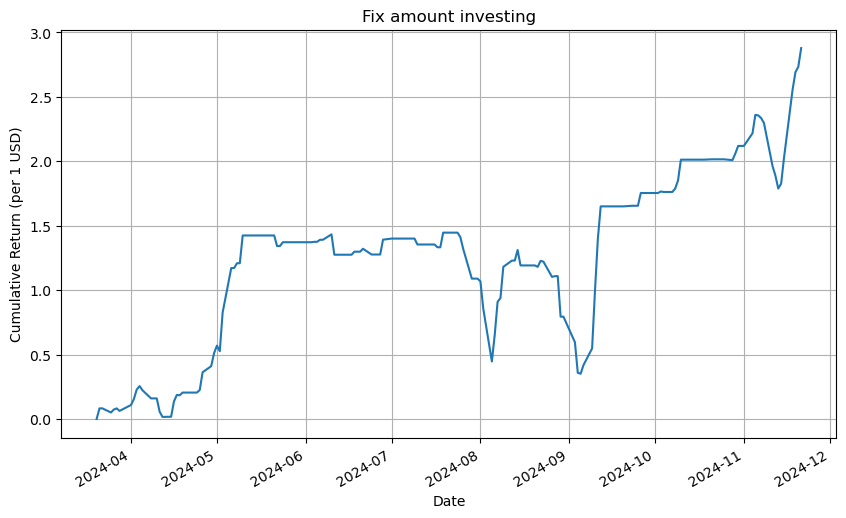

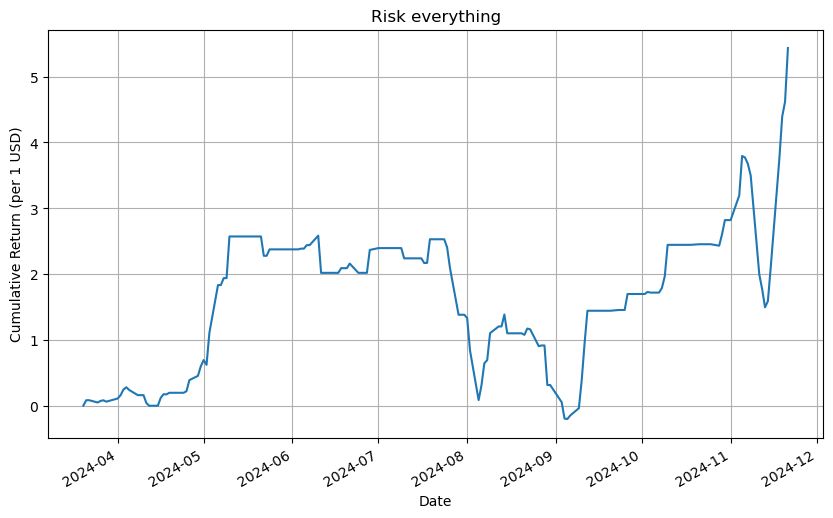

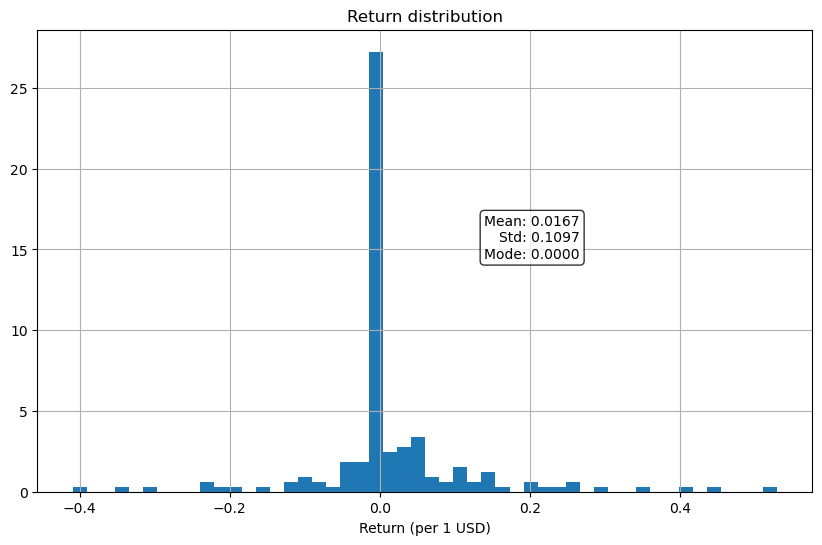

In [24]:
def plot_predictions_by_ticker(return_df):

    fig_size = (10,6)
    
    plt.figure(figsize=fig_size)
    (np.exp(return_df['profit'])-1).cumsum().plot()
    plt.title('Fix amount investing')
    plt.ylabel('Cumulative Return (per 1 USD)')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=fig_size)
    (np.exp(return_df['profit'].cumsum())-1).plot()
    plt.title('Risk everything')
    plt.ylabel('Cumulative Return (per 1 USD)')
    plt.grid(True)
    plt.show()

    returns = np.exp(return_df['profit']) -1 
    mean_return = returns.mean()
    std_return = returns.std()
    mode_return = returns.mode()[0]

    plt.figure(figsize=fig_size)
    returns.hist(density=True, bins=50)
    plt.title('Return distribution')
    stats_text = f'Mean: {mean_return:.4f}\nStd: {std_return:.4f}\nMode: {mode_return:.4f}'
    plt.text(0.7, 0.6, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.xlabel('Return (per 1 USD)')
    plt.grid(True)
    plt.show()
plot_predictions_by_ticker(return_df)

The date is not excatly right, it has been shifted for N_hold_day backward, but this shows the idea.